This lab on Multiclass Support Vector Machines in Python is an adaptation of p. 366-368 of "Introduction to Statistical
Learning with Applications in R" by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani. Original
adaptation by J. Warmenhoven, updated by R. Jordan Crouser at Smith College for SDS293: Machine
Learning (Spring 2016).

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split

%matplotlib inline

# We'll define a function to draw a nice plot of an SVM
def plot_svc(svc, X, y, h=0.02, pad=0.25):
    x_min, x_max = X[:, 0].min()-pad, X[:, 0].max()+pad
    y_min, y_max = X[:, 1].min()-pad, X[:, 1].max()+pad
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.2)

    plt.scatter(X[:,0], X[:,1], s=70, c=y, cmap=mpl.cm.Paired)
    # Support vectors indicated in plot by vertical lines
    sv = svc.support_vectors_
    plt.scatter(sv[:,0], sv[:,1], c='k', marker='x', s=100, linewidths='1')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()
    print('Number of support vectors: ', svc.support_.size)

Below is the dataset we generated during the previous lab:

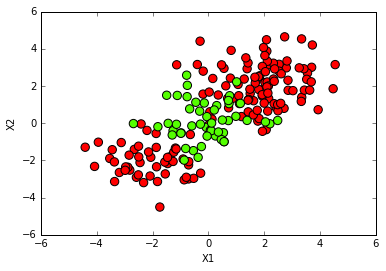

In [2]:
np.random.seed(8)
X = np.random.randn(200,2)
X[:100] = X[:100] +2
X[101:150] = X[101:150] -2
y = np.concatenate([np.repeat(-1, 150), np.repeat(1,50)])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=2)

plt.scatter(X[:,0], X[:,1], s=70, c=y, cmap=plt.cm.prism)
plt.xlabel('X1')
plt.ylabel('X2')

# 9.6.4 SVM with Multiple Classes

If the response is a factor containing more than two levels, then the ${\tt svm()}$
function will perform multi-class classification using the one-versus-one approach.
We explore that setting here by generating a third class of observations:

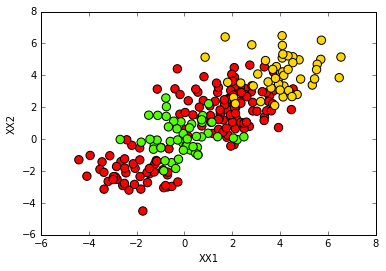

In [3]:
np.random.seed(8)
XX = np.vstack([X, np.random.randn(50,2)])
yy = np.hstack([y, np.repeat(0,50)])
XX[yy ==0] = XX[yy == 0] +4

plt.scatter(XX[:,0], XX[:,1], s=70, c=yy, cmap=plt.cm.prism)
plt.xlabel('XX1')
plt.ylabel('XX2')

Fitting an SVM to multiclass data uses identical syntax to fitting a simple two-class model:

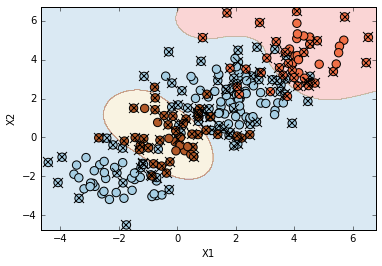

Number of support vectors:  133


In [4]:
svm5 = SVC(C=1, kernel='rbf')
svm5.fit(XX, yy)
plot_svc(svm5, XX, yy)

# 9.6.5 Application to Gene Expression Data

We now examine the ${\tt Khan}$ dataset from the ${\tt ISLR}$ library, which consists of a number of tissue
samples corresponding to **four distinct types** of small round blue cell tumors.
For each tissue sample, gene expression measurements are available.

The data set consists of training data, ${\tt xtrain}$ and ${\tt ytrain}$, and testing data,
${\tt xtest}$ and ${\tt ytest}$. The dataset is kind of large, so I've separated it out into different files for you:

In [5]:
X_train = pd.read_csv('Khan_xtrain.csv').drop('Unnamed: 0', axis=1)
y_train = pd.read_csv('Khan_ytrain.csv').drop('Unnamed: 0', axis=1).as_matrix().ravel()
X_test = pd.read_csv('Khan_xtest.csv').drop('Unnamed: 0', axis=1)
y_test = pd.read_csv('Khan_ytest.csv').drop('Unnamed: 0', axis=1).as_matrix().ravel()

Let's take a look at the dimensions of this dataset:

In [6]:
X_train.shape

(63, 2308)

In [7]:
X_test.shape

(20, 2308)

This data set consists of expression measurements for 2,308 genes.
The training and test sets consist of 63 and 20 observations respectively. Let's see how the classes compare:

In [8]:
pd.Series(y_train).value_counts(sort=False)

1     8
2    23
3    12
4    20
dtype: int64

In [9]:
pd.Series(y_test).value_counts(sort=False)

1    3
2    6
3    6
4    5
dtype: int64

We will use a support vector approach to predict cancer subtype using gene
expression measurements. In this dataset, there are a very large number
of features relative to the number of observations. This suggests that we
should use a **linear kernel**, because the additional flexibility that will result
from using a polynomial or radial kernel is unnecessary.

In [10]:
svc = SVC(kernel='linear')
svc.fit(X_train, y_train)

# Print a nice confusion matrix
cm = confusion_matrix(y_train, svc.predict(X_train))
cm_df = pd.DataFrame(cm.T, index=svc.classes_, columns=svc.classes_)
print(cm_df)

   1   2   3   4
1  8   0   0   0
2  0  23   0   0
3  0   0  12   0
4  0   0   0  20


We see that there are **no training errors**. In fact, this is not surprising,
because the large number of variables relative to the number of observations
implies that it is easy to find hyperplanes that fully separate the classes. We
are most interested not in the support vector classifier’s performance on the
training observations, but rather its performance on the test observations:

In [12]:
cm = confusion_matrix(y_test, svc.predict(X_test))
print(pd.DataFrame(cm.T, index=svc.classes_, columns=svc.classes_))

   1  2  3  4
1  3  0  0  0
2  0  6  2  0
3  0  0  4  0
4  0  0  0  5


We see that using ${\tt cost=10}$ yields two test set errors on this data.

# Problem 9.7.8

Now it's your turn! In this section of the lab, we'll try exploring the ${\tt OJ}$ dataset from the ${\tt ISLR}$ package. The data contains 1070 purchases where the customer either purchased Citrus Hill or Minute Maid
Orange Juice. A number of characteristics of the customer and product are recorded:

In [13]:
df = pd.read_csv('OJ.csv').drop('Unnamed: 0', axis=1)
df.Store7 = df.Store7.map({'No':0, 'Yes':1})
df.head()

,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
0,CH,237,1,1.75,1.99,0.00,0.0,0,0,0.500000,1.99,1.75,0.24,0,0.000000,0.000000,0.24,1
1,CH,239,1,1.75,1.99,0.00,0.3,0,1,0.600000,1.69,1.75,-0.06,0,0.150754,0.000000,0.24,1
2,CH,245,1,1.86,2.09,0.17,0.0,0,0,0.680000,2.09,1.69,0.40,0,0.000000,0.091398,0.23,1
3,MM,227,1,1.69,1.69,0.00,0.0,0,0,0.400000,1.69,1.69,0.00,0,0.000000,0.000000,0.00,1
4,CH,228,7,1.69,1.69,0.00,0.0,0,0,0.956535,1.69,1.69,0.00,1,0.000000,0.000000,0.00,0


Let's start by splitting the dataset into a training set containing a random sample of 800
observations, and a test set containing the remaining
observations:

In [14]:
X = df.drop(['Purchase'], axis=1)
y = df.Purchase

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=800, random_state=0)

In the space below, fit a support vector classifier to the training data, with ${\tt Purchase}$ as the response and the other variables
as predictors:

In [1]:
# Your code here:
svc_linear = 

SyntaxError: invalid syntax (<ipython-input-1-ea2c1888da3c>, line 2)

The code below will generate confusion matrices so we can see how your model does on the training data:

In [16]:
cm = confusion_matrix(y_train, svc_linear.predict(X_train))
print(pd.DataFrame(cm.T, index=svc_linear.classes_, columns=svc_linear.classes_))

     CH   MM
CH  445   73
MM   55  227


And the test data:

In [17]:
cm = confusion_matrix(y_test, svc_linear.predict(X_test))
print(pd.DataFrame(cm.T, index=svc_linear.classes_, columns=svc_linearsvc_linearsvc_linear_tuned.classes_))

     CH  MM
CH  130  25
MM   23  92


Now try using the ${\tt GridSearchCV()}$ function to select an optimal value for ${\tt c}$. Consider values in the range 0.01 to 10:

In [18]:
# Your code here
svc_linear_tuned =

# Performance check
print(confusion_matrix(y_test, svc_linear_tuned.predict(X_test)))
print(svc_linear_tuned.score(X_test, y_test))

Best params:  {'C': 1}
[[130  23]
 [ 25  92]]
0.822222222222


Now try fitting an SVM with ${\tt kernel="rbf"}$, using the default value for ${\tt gamma}$ and cross-validation to find the best value for ${\tt c}$:

In [19]:
# Your code here
svc_radial_tuned =

# Performance check
print(confusion_matrix(y_test, svc_radial_tuned.predict(X_test)))
print(svc_radial_tuned.score(X_test, y_test))

Best params:  {'C': 5}
[[136  17]
 [ 32  85]]
0.818518518519


And now try ${\tt kernel="poly"}$ with ${\tt degree=2}$:

In [ ]:
# Your code here
svc_quadratic_tuned = 

# Performance check
print(confusion_matrix(y_test, svc_quadratic_tuned.predict(X_test)))
print(svc_quadratic_tuned.score(X_test, y_test))

To get credit for this lab, post about your best-performing model on the ${\tt OJ}$ dataset:
 - Which model performed best on the training data? With which parameters?
 - Which model performed best on the test data? With which parameters?
 - What does all this tell you about the dataset?
 
to Piazza: https://piazza.com/class/igwiv4w3ctb6rg?cid=55